<a href="https://colab.research.google.com/github/chaitanyabalajireddy/Team_6_NLP/blob/main/TEAM_6_NLP_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 10.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-many

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import nltk
import stanza
from stanza import Pipeline

# Download the NLTK "punkt" tokenizer data
nltk.download('punkt')

# Load pre-trained model and tokenizer for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Load and set up the Hindi NLP pipeline
stanza.download('hi')
hi_nlp = Pipeline(lang='hi', processors='tokenize,pos')

def pos_tag_hindi(text):
    doc = hi_nlp(text)
    tagged_words = [(word.text, word.pos) for sent in doc.sentences for word in sent.words]
    return tagged_words


# Load your POS word lists (adjust paths as needed)
with open('idxnoun_txt', 'r', encoding='utf-8') as file:
    nouns = set(line.strip().lower() for line in file)

with open('idxadjective_txt', 'r', encoding='utf-8') as file:
    adjectives = set(line.strip().lower() for line in file)

with open('idxadverb_txt', 'r', encoding='utf-8') as file:
    adverbs = set(line.strip().lower() for line in file)

with open('idxverb_txt', 'r', encoding='utf-8') as file:
    verbs = set(line.strip().lower() for line in file)

csv_data_path = "valid.csv"
data = pd.read_csv(csv_data_path)

# Function to classify POS based on the given word lists
def classify_pos(word):
    word_lower = word.lower()
    if word_lower in nouns:
        return 'Noun'
    elif word_lower in adjectives:
        return 'Adjective'
    elif word_lower in adverbs:
        return 'Adverb'
    elif word_lower in verbs:
        return 'Verb'
    else:
        return 'Unknown'

# Function to analyze sentiment using a pre-trained multilingual model
def get_word_sentiment(word):
    inputs = tokenizer(word, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    positive_score = probabilities[0, -1].item()  # Assumes the last class is positive
    negative_score = probabilities[0, 0].item()  # Assumes the first class is negative
    return positive_score, negative_score

# Analyze each word in each post of the dataset
results = []
for index, row in data.iterrows():
    post_text = row['Post']
    unique_id = row['Unique ID']
    label = row.get('Labels Set', '')

    tokens = nltk.word_tokenize(post_text)

    for token in tokens:
        pos = pos_tag_hindi(token)
        positive_score, negative_score = get_word_sentiment(token)

        results.append([
            unique_id,
            token,
            pos[0][1],
            positive_score,
            negative_score,
            label
        ])

# Convert results to a DataFrame for better organization
output_df = pd.DataFrame(results, columns=['Unique ID', 'word', 'pos', 'positive_score', 'negative_score', 'label'])

# Save the results to a new CSV file
output_csv_path = "output_data_per_word.csv"
output_df.to_csv(output_csv_path, index=False)

print(output_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: hi (Hindi) ...
INFO:stanza:File exists: /root/stanza_resources/hi/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: hi (Hindi):
| Processor | Package     |
---------------------------
| tokenize  | hdtb        |
| pos       | hdtb_charlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Done loading processors!


       Unique ID      word    pos  positive_score  negative_score        label
0              1      दृढ़    ADJ        0.085628        0.123780  non-hostile
1              1     इच्छा   NOUN        0.402432        0.030737  non-hostile
2              1     शक्ति   NOUN        0.508729        0.040295  non-hostile
3              1        से    ADP        0.282674        0.128888  non-hostile
4              1  परिपूर्ण    ADJ        0.273673        0.123435  non-hostile
...          ...       ...    ...             ...             ...          ...
27438        811       खबर   NOUN        0.236085        0.126253         fake
27439        811      2020  PROPN        0.271829        0.125390         fake
27440        811       में    ADP        0.265235        0.110232         fake
27441        811         !  PUNCT        0.478329        0.093450         fake
27442        811         !  PUNCT        0.478329        0.093450         fake

[27443 rows x 6 columns]


# Subjectivity Analysis
- We use Sentiment lexicon resource for hindi called Hindi Sentiwordnet.
- It has around 3000 prior-polarity subjective clues with POS tag, positive score, negative score and related terms(separated by comma)

In [2]:
SUBJCLUE = []                     # SUBJCLUE Data

with open('SUBJCLUE.txt') as f:   # Formatting SUBJCLUE Data
    for line in f:                # iterate over the lines of the file
      x = line.split()            # split the line into a list of words
      x[4] = x[4].split(',')      # split the list into a list of words
      SUBJCLUE.append(x)          # append the list to the list of lists

# After this, the data would be in this form:
# ['POS tag', 'SYSNET ID(Hindi WN)', 'Positive score', 'Negative score', List of related words]

# printing the first 5 rows
for key in SUBJCLUE[:5]:
  print(key[4])


['अनौपचारिक']
['मृत']
['परवर्ती']
['अच्छा', 'बढ़िया']
['सौभाग्यशाली', 'खुशकिस्मत', 'खुशनसीब', 'तक़दीर_वाला', 'नसीब_वाला', 'भाग्यवान', 'भाग्यशाली', 'ख़ुशक़िस्मत', 'ख़ुशनसीब']


## Reading the data


Note: The Dataset should be a csv file with Fields corresponding to Unique ID, Post, Labels Set

In [3]:
import csv                                  # importing csv module
# csv file name

filename = "valid.csv"                      # change this file name to whatever you want


fields = []                                 # defining fields
rows = []                                   # defining rows

with open(filename, 'r') as csvfile:        # opening csv file
    # creating a csv reader object
    csvreader = csv.reader(csvfile)

    # extracting field names through first row
    fields = next(csvreader)

    # extracting each data row one by one
    for row in csvreader:
        rows.append(row)

    # get total number of rows
    print("Total no. of rows: %d"%(csvreader.line_num))

# printing the field names
print('Field names are:' + ', '.join(field for field in fields))

#  printing first 5 rows
# Appending a score for each row
tot = 0
for row in rows:
    row.append(tot)
    # print(row)
# can be accessed using row[3]
for row in rows[:5]:
  print(row)

Total no. of rows: 2259
Field names are:Unique ID, Post, Labels Set
['1', 'दृढ़ इच्छा शक्ति से परिपूर्ण प्रणबदा के लिए देशहित सर्वोच्च रहा।\n\nउनका निधन हम सब के लिए अपूरणीय क्षति है।\nईश्वर दिवंगत आत्मा को अपने श्रीचरणों में स्थान दें। शोक संतप्त परिजनों के प्रति संवेदनाएं।\nऊं शांति!!!', 'non-hostile', 0]
['2', 'भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं जहां मैं रहती हूं वहां मेरी जासूसी  करा रहें है उसकी जासूस की पहचान मुझे अच्छी तरह है rss बीजेपी वाले की जासूस दिल्ली में कौन है उत्तर प्रदेश में कौन है हरियाणा राजस्थान में कौन है सबकी पहचान है मुझे मेरी नजर से बच नहीं सकते हो', 'defamation', 0]
['3', 'कोरोना से निपटने की तैयारी / दिल्ली में 10 हजार बेड वाला दुनिया का सबसे बड़ा कोविड केयर सेंटर शुरू, राजनाथ-शाह ने डीआरडीओ के 1 हजार बेड वाले सेंटर का भी उद्घाटन किया\nhttps://t.co/9rlQowAsFh #Delhi @ArvindKejriwal  @rajnathsingh @AmitShah @DRDO_India @WHO @crpfindia @ITBP_official', 'non-hostile', 0]
['4', 'गवर्नर कॉन्फ्रेंस में PM मोदी बोले- शिक्षा नीति में सरकार का दखल कम होना चा

## Checking score

Finding positive, negative and total scores for each sentence



In [4]:
count = 0                             # initialize count
for key in SUBJCLUE:                  # for each word in SUBJCLUE
  subjlist = key[4]                   # get the list of subjects
# subjlist = ['इच्छा', 'आत्मा', 'इतने']
  for row in rows:                    # for each row in the csv file
    if any([subjword in row[1] for subjword in subjlist]):  # if any of the words in the list are in the row's text
      count += 1            # increment count
      pos = float(key[2])   # get the pos value
      neg = float(key[3])   # get the neg value
      tot = pos - neg       # calculate the total
      row[3] += tot         # add the total to the row's total

# printing the number of occurences of sentiment words in dataset
print(count)

10530


# Hate Lexicon Growing


In [11]:
# Installing required modules
!pip install stanza
!pip install setuptools
!pip install subzero
!pip install inltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 36.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

ERROR: Operation cancelled by user


In [5]:
SYNSET = []                                                     # SYNSET is a list of lists
with open('Synset.txt', encoding= 'unicode_escape') as f:       # opening synset.txt file
    for line in f:                                              # iterating through SYNSET
        x = line.split()                                        # splitting lines
        x[3] = x[3].split(':')                                  # [3] is the synonyms
        SYNSET.append(x)                                        # append to SYNSET

import stanza                                                   # stanza is a library for natural language processing
stanza.download('hi', processors='tokenize,pos,lemma')          # download the stanza library for Hindi NLP

import csv                                                      # csv is a library for reading and writing csv files
dataset = ""                                                    # dataset is a string

for row in rows:                                                # iterating through rows
    dataset+=row[1]                                             # appending to dataset

verbs_content = []                                              # verbs_content is a list of lists
nlp = stanza.Pipeline('hi',processors='tokenize,pos,lemma')     # nlp is a pipeline for processing text
# pos = open('hindi_pos.txt','w')                                 # opening hindi_pos.txt in write mode
doc = nlp(dataset)                                              # doc is a document object
for sentence in doc.sentences:                                  # iterating through sentences
     for word in sentence.words:                                # iterating through words
         if word.upos == 'VERB':                                # if word is a verb
             verbs_content.append(word.text)                    # append to verbs_content

strongly_negative_words = []                                    # strongly_negative_words is a list
weakly_negative_words = []                                      # weakly_negative_words is a list
for line in SUBJCLUE:                                           # iterating through SUBJCLUE
    totalscore = float(line[2]) - float(line[3])                # calculating total score
    if(totalscore < -0.25):                                     # if total score is less than -0.35
      for word in line[4]:                                      # iterating through words in line[4]
        strongly_negative_words.append(word)                    # append to strongly_negative_words
    elif totalscore < 0:                                        # if total score is less than 0
      for word in line[4]:                                      # iterating through words in line[4]
        weakly_negative_words.append(word)                      # append to weakly_negative_words

def Getsynset(word):                                            # Getsynset is a function
    syn = []                                                    # syn is a list
    flag=0                                                      # flag is a variable
    syn.append(word)                                            # appending word to syn
    for line in SYNSET:                                         # iterating through SYNSET
        if(line[1]=="03"):                                      # if line[1] is equal to 03
            for verb in line[3]:                                # iterating through verbs in line[3]
                if(word == verb):                               # if word is equal to verb
                    flag = 1                                    # flag is set to 1
                    break                                       # break
            if(flag):                                           # if flag is set to 1
                syn = line[3]                                   # syn is set to line[3]
                break                                           # break
    return syn                                                  # return syn

s = {}                                                          # s is a dictionary
hlex = []                                                       # hlex is a list

slist = ["लड़ना" , "मारना" , "लूटना" , "पीटना" , "कूटना" , "भेदभाव" ,"फोड़ना", "तोड़ना", "उखाड़ना" ]    # slist is a list of verbs
for word in slist:                                                                              # iterating through slist
  hlex.append(word)                                                                             # appending to hlex
for word in slist:                                                                              # iterating through slist
    s = Getsynset(word)                                                                         # s is set to Getsynset
    for verb1 in s:                                                                             # iterating through s
        if verb1 in verbs_content:                                                              # if verb1 is in verbs_content
            hlex.append(verb1)                                                                  # appending to hlex


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading these customized packages for language: hi (Hindi)...
| Processor       | Package       |
-----------------------------------
| tokenize        | hdtb          |
| pos             | hdtb_charlm   |
| lemma           | hdtb_nocharlm |
| backward_charlm | oscar         |
| pretrain        | conll17       |
| forward_charlm  | oscar         |

INFO:stanza:File exists: /root/stanza_resources/hi/tokenize/hdtb.pt
INFO:stanza:File exists: /root/stanza_resources/hi/pos/hdtb_charlm.pt
INFO:stanza:File exists: /root/stanza_resources/hi/lemma/hdtb_nocharlm.pt
INFO:stanza:File exists: /root/stanza_resources/hi/backward_charlm/oscar.pt
INFO:stanza:File exists: /root/stanza_resources/hi/pretrain/conll17.pt
INFO:stanza:File exists: /root/stanza_resources/hi/forward_charlm/oscar.pt
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in 

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: hi (Hindi):
| Processor | Package       |
-----------------------------
| tokenize  | hdtb          |
| pos       | hdtb_charlm   |
| lemma     | hdtb_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [6]:
# open themenouns.txt in read
themed_nouns = open('themenouns.txt','r')
themenouns = []                                 # list of theme nouns
for line in themed_nouns:                       # read the file line by line
    themenouns.append(line.rstrip('\n'))        # append the theme nouns to the list
print(themenouns)                               # printing the theme nouns list

['बीजेपी ', 'मोदी ', 'माओवादियों ', 'इस्लाम ', 'धमकी ', 'सुरक्षा ', 'धर्म ', 'साले ', 'कुत्ते ', 'कुतिया', 'कुते ', 'कुत्ती', 'कुत्तो', 'कमीना', 'कमीनी', 'साला', 'साली', 'हरामी', 'हरामखोर', 'बहनचोद', 'मादरचोद', 'चूतिया', 'चूत', 'चुत', 'टट्टी', 'नाजायज', 'झांट', 'सुअर', 'बेटीचोद', 'गांड', 'भोसड़ी', 'रन्डी', 'रांड', 'भड़वे', 'लौड़ा', 'लोडे', 'लवड़ा', 'चोर ', 'औलाद ', 'चीन ', 'औकात ', 'चुनौती', 'कश्मीर ', 'ज़ुल्म ', 'मरकज ', 'भारत', 'आतंकवाद', 'इस्लामिक', 'तालिबानी', 'हिन्दू ', 'अर्नब ', 'गद्दारों ', 'कलंकित ', 'तोड़फोड़ ', 'शिवसेना ', 'मंदिर ', 'राम ', 'हिन्दुओं ', 'शूद्र ', 'मुसलमान ', 'विपक्षी ', 'आग ', 'कॉंग्रेस ', 'आतंकवादी ', 'डायन ', 'पलटू ', 'फेंकूँ ', 'पाकिस्तान ', 'जिंदाबाद ', 'आतंकी ', 'आतंकी ', 'आतंकियों ', 'हिंदुस्तान ', 'हिन्दुओं', 'नेता', 'गुलाम ', 'पीओके ', 'आरएसएस ', 'भैंसियो ', 'चमचों ', 'पिल्ला ', 'गधे ', 'तबाह ', 'मुसलमान ', 'मुसलमानों ', 'मौलवी ', 'धर्म ']


# Hate speech Detection Algorithm

In [7]:
print(strongly_negative_words)  # printing the strongly negative words
print(weakly_negative_words)    # printing the weakly negative words
print(hlex)                     # printing the hlex words
print(themenouns)               # printing the themenouns

['मृत', 'दुर्भाग्यशाली', 'अभागा', 'बदनसीब', 'भाग्यहीन', 'मनहूस', 'बदकिस्मत', 'मंदभाग्य', 'बदक़िस्मत', 'दईमारा', 'कमबख्त', 'कमबख़्त', 'अधन्य', 'अभागी', 'आवासहीन', 'आश्रयहीन', 'गृहहीन', 'गृहविहीन', 'बेघर', 'बेघरबार', 'अगतिक', 'अगेह', 'अनिकेत', 'बदबूदार', 'दुर्गंधपूर्ण', 'दुर्गंधयुक्त', 'दुर्गंधित', 'ढीला', 'अश्लिष्ट', 'असंयुक्त', 'असंयोजित', 'असंबद्ध', 'अलग', 'अजुड़ा', 'अजोड़', 'पृथक्', 'जुदा', 'पृथक', 'अपृक्त', 'पराधीन', 'गुलाम', 'परतंत्र', 'अन्याधीन', 'अपरवश', 'परवश', 'अवश', 'अबस', 'ढीला', 'जड़', 'अचैतन्य', 'जड़त्वयुक्त', 'स्थूल', 'अजैव', 'भौतिक', 'अचेतन', 'चेतनारहित', 'अजीव', 'अनात्म', 'आत्मारहित', 'अफल', 'अफलित', 'फलहीन', 'फलरहित', 'फलविहीन', 'निस्संतान', 'निःसंतान', 'बेऔलाद', 'संतानहीन', 'संतानरहित', 'अऊत', 'अनपत्य', 'भली-भाँति', 'भली_भाँति', 'भरपूर', 'भलीभाँति', 'भली-भांति', 'भली_भांति', 'भलीभांति', 'पंखहीन', 'पक्षरहित', 'अपक्ष', 'अपच्छी', 'अपत्र', 'अतकनीकी', 'ग़ैरतकनीकी', 'गैरतकनीकी', 'तकनीकहीन', 'प्राविधिहीन', 'दुर्गुणी', 'अगुणी', 'अपगुणी', 'ऐबी', 'खोटा', 'विपरीत', 'प्रतिकूल', 'ख

## Calculating Scores without Subjective Analysis

### Only Semantic feature set

In [8]:
for row in rows:                                                      # Iterate over all rows
    strongcount = 0                                                   # Initialize strong count
    hlexcount = 0                                                     # Initialize hlex count
    weakcount = 0                                                     # Initialize weak count
    themecount = 0                                                    # Initialize theme count
    if any([word in row[1] for word in strongly_negative_words]):     # If any of the strongly negative words are in the tweet
      strongcount += 1                                                # Increment strong count
    # if any([word in row[1] for word in hlex]):                        # If any of the hlex words are in the tweet
    #   hlexcount += 1                                                  # Increment hlex count
    if any([word in row[1] for word in weakly_negative_words]):       # If any of the weakly negative words are in the tweet
      weakcount += 1                                                  # Increment weak count
    # if any([word in row[1] for word in themenouns]):                  # If any of the theme nouns are in the tweet
    #   themecount += 1                                                 # Increment theme count

    if strongcount >= 2:                                              # If strong count is greater than or equal to 2
        row.append("strongly hateful")                               # Append strongly hateful to the row
    elif strongcount == 1:                                            # Else if strong count is 1
      if hlexcount >= 1 or themecount >= 1:                           # If hlex count is 1 or theme count is 1
        row.append("strongly hateful")                                # Append strongly hateful to the row
      else:                                                           # Else
        row.append("weakly hateful")                                  # Append weakly hateful to the row
    elif strongcount == 0:                                            # Else if strong count is 0
      if themecount >= 1 and hlexcount >= 1:                          # If theme count is 1 and hlex count is 1
        row.append("strongly hateful")                                # Append strongly hateful to the row
      elif themecount >=1 and weakcount >= 1:                         # Else if theme count is 1 and weak count is 1
        row.append("weakly hateful")                                  # Append weakly hateful to the row
      elif hlexcount == 1:                                            # Else if hlex count is 1
        row.append("weakly hateful")                                  # Append weakly hateful to the row
      else:                                                           # Else
        row.append("No Hate")                                         # Append No Hate to the row


# total rows = toal number of rows
total_rows = [row for row in rows]

# no_hate_rows = number of rows that are marked to have no hate
no_hate_rows = [row for row in rows if row[4] == "No Hate"]
# correct_no_hate_rows = number of rows that have no hate speech and are correctly marked
correct_no_hate_rows = [row for row in no_hate_rows if row[4] == "No Hate" and row[2] == "non-hostile"]
# weak_hate_rows = number of rows that are marked to have weak hate
weak_hate_rows = [row for row in rows if row[4] == "weakly hateful"]
# correct_weak_hate_rows = number of rows that have weak hate speech and are correctly marked
correct_weak_hate_rows = [row for row in weak_hate_rows if row[4] == "weakly hateful" and (row[2] == "fake" or row[2] == "defamation")]
# strong_hate_rows = number of rows that are marked to have strong hate
strong_hate_rows = [row for row in rows if row[4] == "strongly hateful"]
# correct_strong_hate_rows = number of rows that have strong hate speech and are correctly marked
correct_strong_hate_rows = [row for row in strong_hate_rows if row[4] == "strongly hateful" and row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation"]
# false negatives in the no hate list
false_neg_no_hate = [row for row in no_hate_rows if row[2] == "non-hostile" and row[4] != "No Hate"]
# false negatives in the weak hate list
false_neg_weak_hate = [row for row in weak_hate_rows if row[2] == "fake" or row[2] == "defamation" and row[4] != "weakly hateful"]
# false negatives in the strong hate list
false_neg_strong_hate = [row for row in strong_hate_rows if row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation" and row[4] != "strongly hateful"]

# calculating precision
precision = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(no_hate_rows)+len(strong_hate_rows)+len(weak_hate_rows))
# calculating recall
recall = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows)+len(false_neg_no_hate)+len(false_neg_strong_hate)+len(false_neg_weak_hate))
# calculating F1 score
f1 = 2*precision*recall/(precision+recall)

print("Total no. of rows: {}".format(len(total_rows)))                  # total no. of rows
print("No Hate: {}".format(len(no_hate_rows)))                          # no hate rows
print("Actual no hate: {}".format(len(correct_no_hate_rows)))           # actual no hate rows
print("Weak Hate: {}".format(len(weak_hate_rows)))                      # weak hate rows
print("Actual weak hate: {}".format(len(correct_weak_hate_rows)))       # actual weak hate rows
print("Strong Hate: {}".format(len(strong_hate_rows)))                  # strong hate rows
print("Actual strong hate: {}".format(len(correct_strong_hate_rows)))   # actual strong hate rows
# print precision
print("Precision: {}".format(precision))
# print recall
print("Recall: {}".format(recall))
# print f1
print("F-score: {}".format(f1))

Total no. of rows: 811
No Hate: 357
Actual no hate: 207
Weak Hate: 454
Actual weak hate: 112
Strong Hate: 0
Actual strong hate: 0
Precision: 0.3933415536374846
Recall: 0.7799511002444988
F-score: 0.5229508196721312


### Semantic + Hate Lexicon

In [9]:
for row in rows:                                                      # Iterate over all rows
    strongcount = 0                                                   # Initialize strong count
    hlexcount = 0                                                     # Initialize hlex count
    weakcount = 0                                                     # Initialize weak count
    themecount = 0                                                    # Initialize theme count
    if any([word in row[1] for word in strongly_negative_words]):     # If any of the strongly negative words are in the tweet
      strongcount += 1                                                # Increment strong count
    if any([word in row[1] for word in hlex]):                        # If any of the hlex words are in the tweet
      hlexcount += 1                                                  # Increment hlex count
    if any([word in row[1] for word in weakly_negative_words]):       # If any of the weakly negative words are in the tweet
      weakcount += 1                                                  # Increment weak count
    # if any([word in row[1] for word in themenouns]):                  # If any of the theme nouns are in the tweet
    #   themecount += 1                                                 # Increment theme count

    if strongcount >= 2:                                              # If strong count is greater than or equal to 2
        row[4] = "strongly hateful"                                # Append strongly hateful to the row
    elif strongcount == 1:                                            # Else if strong count is 1
      if hlexcount >= 1 or themecount >= 1:                           # If hlex count is 1 or theme count is 1
        row[4] = "strongly hateful"                                # Append strongly hateful to the row
      else:                                                           # Else
        row[4] = "weakly hateful"                                  # Append weakly hateful to the row
    elif strongcount == 0:                                            # Else if strong count is 0
      if themecount >= 1 and hlexcount >= 1:                          # If theme count is 1 and hlex count is 1
        row[4] = "strongly hateful"                                # Append strongly hateful to the row
      elif themecount >=1 and weakcount >= 1:                         # Else if theme count is 1 and weak count is 1
        row[4] = "weakly hateful"                                  # Append weakly hateful to the row
      elif hlexcount == 1:                                            # Else if hlex count is 1
        row[4] = "weakly hateful"                                  # Append weakly hateful to the row
      else:                                                           # Else
        row[4] = "No Hate"                                        # Append No Hate to the row


# total rows = toal number of rows
total_rows = [row for row in rows]

# no_hate_rows = number of rows that are marked to have no hate
no_hate_rows = [row for row in rows if row[4] == "No Hate"]
# correct_no_hate_rows = number of rows that have no hate speech and are correctly marked
correct_no_hate_rows = [row for row in no_hate_rows if row[4] == "No Hate" and row[2] == "non-hostile"]
# weak_hate_rows = number of rows that are marked to have weak hate
weak_hate_rows = [row for row in rows if row[4] == "weakly hateful"]
# correct_weak_hate_rows = number of rows that have weak hate speech and are correctly marked
correct_weak_hate_rows = [row for row in weak_hate_rows if row[4] == "weakly hateful" and (row[2] == "fake" or row[2] == "defamation")]
# strong_hate_rows = number of rows that are marked to have strong hate
strong_hate_rows = [row for row in rows if row[4] == "strongly hateful"]
# correct_strong_hate_rows = number of rows that have strong hate speech and are correctly marked
correct_strong_hate_rows = [row for row in strong_hate_rows if row[4] == "strongly hateful" and row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation"]
# false negatives in the no hate list
false_neg_no_hate = [row for row in no_hate_rows if row[2] == "non-hostile" and row[4] != "No Hate"]
# false negatives in the weak hate list
false_neg_weak_hate = [row for row in weak_hate_rows if row[2] == "fake" or row[2] == "defamation" and row[4] != "weakly hateful"]
# false negatives in the strong hate list
false_neg_strong_hate = [row for row in strong_hate_rows if row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation" and row[4] != "strongly hateful"]

# calculating precision
precision = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(no_hate_rows)+len(strong_hate_rows)+len(weak_hate_rows))
# calculating recall
recall = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows)+len(false_neg_no_hate)+len(false_neg_strong_hate)+len(false_neg_weak_hate))
# calculating F1 score
f1 = 2*precision*recall/(precision+recall)

print("Total no. of rows: {}".format(len(total_rows)))                  # total no. of rows
print("No Hate: {}".format(len(no_hate_rows)))                          # no hate rows
print("Actual no hate: {}".format(len(correct_no_hate_rows)))           # actual no hate rows
print("Weak Hate: {}".format(len(weak_hate_rows)))                      # weak hate rows
print("Actual weak hate: {}".format(len(correct_weak_hate_rows)))       # actual weak hate rows
print("Strong Hate: {}".format(len(strong_hate_rows)))                  # strong hate rows
print("Actual strong hate: {}".format(len(correct_strong_hate_rows)))   # actual strong hate rows
# print precision
print("Precision: {}".format(precision))
# print recall
print("Recall: {}".format(recall))
# print f1
print("F-score: {}".format(f1))

Total no. of rows: 811
No Hate: 355
Actual no hate: 206
Weak Hate: 455
Actual weak hate: 112
Strong Hate: 1
Actual strong hate: 1
Precision: 0.3933415536374846
Recall: 0.7799511002444988
F-score: 0.5229508196721312


### Semantic + Hate Lexicon + Thematic Nouns

In [10]:
for row in rows:                                                      # Iterate over all rows
    strongcount = 0                                                   # Initialize strong count
    hlexcount = 0                                                     # Initialize hlex count
    weakcount = 0                                                     # Initialize weak count
    themecount = 0                                                    # Initialize theme count
    if any([word in row[1] for word in strongly_negative_words]):     # If any of the strongly negative words are in the tweet
      strongcount += 1                                                # Increment strong count
    if any([word in row[1] for word in hlex]):                        # If any of the hlex words are in the tweet
      hlexcount += 1                                                  # Increment hlex count
    if any([word in row[1] for word in weakly_negative_words]):       # If any of the weakly negative words are in the tweet
      weakcount += 1                                                  # Increment weak count
    if any([word in row[1] for word in themenouns]):                  # If any of the theme nouns are in the tweet
      themecount += 1                                                 # Increment theme count

    if strongcount >= 2:                                              # If strong count is greater than or equal to 2
        row[4] = "strongly hateful"                                # Append strongly hateful to the row
    elif strongcount == 1:                                            # Else if strong count is 1
      if hlexcount >= 1 or themecount >= 1:                           # If hlex count is 1 or theme count is 1
        row[4] = "strongly hateful"                                # Append strongly hateful to the row
      else:                                                           # Else
        row[4] = "weakly hateful"                                  # Append weakly hateful to the row
    elif strongcount == 0:                                            # Else if strong count is 0
      if themecount >= 1 and hlexcount >= 1:                          # If theme count is 1 and hlex count is 1
        row[4] = "strongly hateful"                                # Append strongly hateful to the row
      elif themecount >=1 and weakcount >= 1:                         # Else if theme count is 1 and weak count is 1
        row[4] = "weakly hateful"                                  # Append weakly hateful to the row
      elif hlexcount == 1:                                            # Else if hlex count is 1
        row[4] = "weakly hateful"                                 # Append weakly hateful to the row
      else:                                                           # Else
        row[4] = "No Hate"                                        # Append No Hate to the row


# total rows = toal number of rows
total_rows = [row for row in rows]

# no_hate_rows = number of rows that are marked to have no hate
no_hate_rows = [row for row in rows if row[4] == "No Hate"]
# correct_no_hate_rows = number of rows that have no hate speech and are correctly marked
correct_no_hate_rows = [row for row in no_hate_rows if row[4] == "No Hate" and row[2] == "non-hostile"]
# weak_hate_rows = number of rows that are marked to have weak hate
weak_hate_rows = [row for row in rows if row[4] == "weakly hateful"]
# correct_weak_hate_rows = number of rows that have weak hate speech and are correctly marked
correct_weak_hate_rows = [row for row in weak_hate_rows if row[4] == "weakly hateful" and (row[2] == "fake" or row[2] == "defamation")]
# strong_hate_rows = number of rows that are marked to have strong hate
strong_hate_rows = [row for row in rows if row[4] == "strongly hateful"]
# correct_strong_hate_rows = number of rows that have strong hate speech and are correctly marked
correct_strong_hate_rows = [row for row in strong_hate_rows if row[4] == "strongly hateful" and row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation"]
# false negatives in the no hate list
false_neg_no_hate = [row for row in no_hate_rows if row[2] == "non-hostile" and row[4] != "No Hate"]
# false negatives in the weak hate list
false_neg_weak_hate = [row for row in weak_hate_rows if row[2] == "fake" or row[2] == "defamation" and row[4] != "weakly hateful"]
# false negatives in the strong hate list
false_neg_strong_hate = [row for row in strong_hate_rows if row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation" and row[4] != "strongly hateful"]

# calculating precision
precision = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(no_hate_rows)+len(strong_hate_rows)+len(weak_hate_rows))
# calculating recall
recall = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows)+len(false_neg_no_hate)+len(false_neg_strong_hate)+len(false_neg_weak_hate))
# calculating F1 score
f1 = 2*precision*recall/(precision+recall)

print("Total no. of rows: {}".format(len(total_rows)))                  # total no. of rows
print("No Hate: {}".format(len(no_hate_rows)))                          # no hate rows
print("Actual no hate: {}".format(len(correct_no_hate_rows)))           # actual no hate rows
print("Weak Hate: {}".format(len(weak_hate_rows)))                      # weak hate rows
print("Actual weak hate: {}".format(len(correct_weak_hate_rows)))       # actual weak hate rows
print("Strong Hate: {}".format(len(strong_hate_rows)))                  # strong hate rows
print("Actual strong hate: {}".format(len(correct_strong_hate_rows)))   # actual strong hate rows
# print precision
print("Precision: {}".format(precision))
# print recall
print("Recall: {}".format(recall))
# print f1
print("F-score: {}".format(f1))

Total no. of rows: 811
No Hate: 293
Actual no hate: 185
Weak Hate: 344
Actual weak hate: 85
Strong Hate: 174
Actual strong hate: 75
Precision: 0.4254007398273736
Recall: 0.843520782396088
F-score: 0.5655737704918032


## Exporting results into results.csv

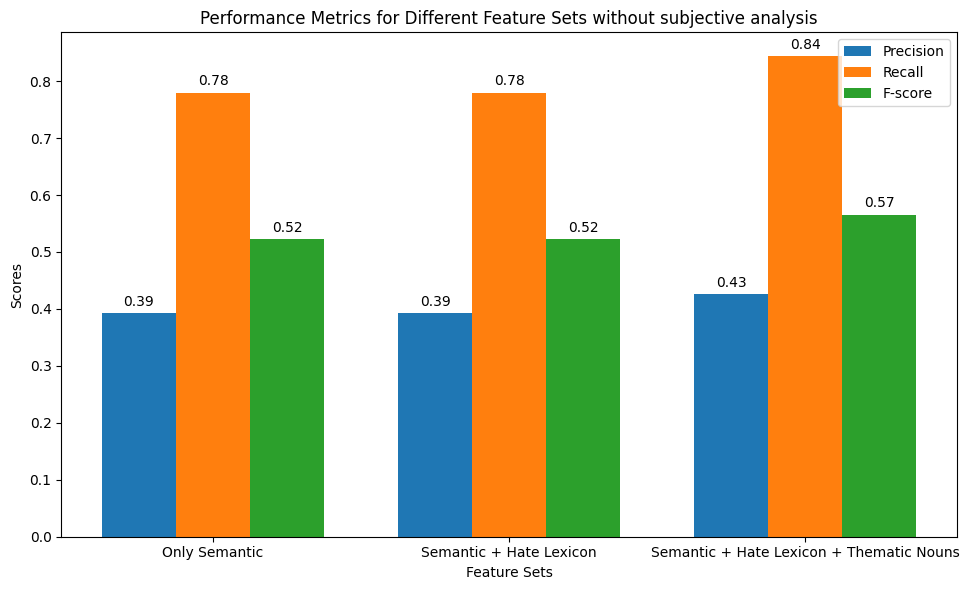

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the different feature sets
feature_sets = [
    'Only Semantic',
    'Semantic + Hate Lexicon',
    'Semantic + Hate Lexicon + Thematic Nouns'
]

precision = [
    0.3933415536374846,
    0.3933415536374846,
    0.4254007398273736
]

recall = [
    0.7799511002444988,
    0.7799511002444988,
    0.843520782396088
]

f_score = [
    0.5229508196721312,
    0.5229508196721312,
    0.5655737704918032
]

# Number of feature sets
n = len(feature_sets)

# The x locations for the groups
ind = np.arange(n)

# The width of the bars
width = 0.25

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(ind - width, precision, width, label='Precision')
bar2 = ax.bar(ind, recall, width, label='Recall')
bar3 = ax.bar(ind + width, f_score, width, label='F-score')

# Adding labels
ax.set_xlabel('Feature Sets')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for Different Feature Sets without subjective analysis')
ax.set_xticks(ind)
ax.set_xticklabels(feature_sets)
ax.legend()

# Adding the scores above the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.2f' % height,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Show plot
plt.tight_layout()
plt.show()


## Calculating Scores with Subjective Analysis

In [11]:
counter = 0                             # Counter for the number of tweets
subj_rows = []                          # List of all the subjective tweets
for row in rows:                        # Iterate through each row
  if row[3] <= -0.5 or row[3] >= 1:     # subjective sentence condition
    subj_rows.append(row)               # Append the row to the list
    counter += 1

print("Number of Subjective Sentences: ")
print(counter)                          # Print the number of subjective tweets

Number of Subjective Sentences: 
355


### Semantic feature set

In [12]:
for row in rows:                                                    # Iterate over all rows
  if row[3] <= -0.5 or row[3] >= 1:                                 # If the score is over -0.5 or 0.5
    strongcount = 0                                                 # Set strongcount to 0
    hlexcount = 0                                                   # Set hlexcount to 0
    weakcount = 0                                                   # Set weakcount to 0
    themecount = 0                                                  # Set themecount to 0
    if any([word in row[1] for word in strongly_negative_words]):   # If any of the strongly negative words are in the tweet
      strongcount += 1                                              # Add 1 to strongcount
    # if any([word in row[1] for word in hlex]):                      # If any of the hlex words are in the tweet
    #   hlexcount += 1                                                # Add 1 to hlexcount
    if any([word in row[1] for word in weakly_negative_words]):     # If any of the weakly negative words are in the tweet
      weakcount += 1                                                # Add 1 to weakcount
    # if any([word in row[1] for word in themenouns]):                # If any of the themenouns words are in the tweet
    #   themecount += 1                                               # Add 1 to themecount

    if strongcount >= 2:                                            # If strongcount is greater than or equal to 2
        row.append("strongly hateful")                              # Append strongly hate to the row
    elif strongcount == 1:                                          # Else if strongcount is equal to 1
      if hlexcount >= 1 or themecount >= 1:                         # If hlexcount is greater than or equal to 1 or themecount is greater than or equal to 1
        row.append("strongly hateful")                              # Append strongly hate to the row
      else:                                                         # Else
        row.append("weakly hateful")                                # Append weakly hate to the row
    elif strongcount == 0:                                          # Else if strongcount is equal to 0
      if themecount >= 1 and hlexcount >= 1:                        # If themecount is greater than or equal to 1 and hlexcount is greater than or equal to 1
        row.append("strongly hateful")                              # Append strongly hate to the row
      elif themecount >=1 and weakcount >= 1:                       # Else if themecount is greater than or equal to 1 and weakcount is greater than or equal to 1
        row.append("weakly hateful")                                # Append weakly hate to the row
      elif hlexcount == 1:                                          # Else if hlexcount is equal to 1
        row.append("weakly hateful")                                # Append weakly hate to the row
      else:                                                         # Else
        row.append("No Hate")                                       # Append No Hate to the row
  else:                                                             # Else
     row.append("No Hate")                                          # Append No Hate to the row


total_rows = [row for row in rows]

no_hate_rows = [row for row in rows if row[5] == "No Hate"]
correct_no_hate_rows = [row for row in no_hate_rows if row[5] == "No Hate" and row[2] == "non-hostile"]
weak_hate_rows = [row for row in rows if row[5] == "weakly hateful"]
correct_weak_hate_rows = [row for row in weak_hate_rows if row[5] == "weakly hateful" and (row[2] == "fake" or row[2] == "defamation")]
strong_hate_rows = [row for row in rows if row[5] == "strongly hateful"]
correct_strong_hate_rows = [row for row in strong_hate_rows if row[5] == "strongly hateful" and row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation"]

false_neg_no_hate = [row for row in no_hate_rows if row[2] == "non-hostile" and row[5] != "No Hate"]
false_neg_weak_hate = [row for row in weak_hate_rows if row[2] == "fake" or row[2] == "defamation" and row[5] != "weakly hateful"]
false_neg_strong_hate = [row for row in strong_hate_rows if row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation" and row[5] != "strongly hateful"]

precision = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(no_hate_rows)+len(strong_hate_rows)+len(weak_hate_rows))
recall = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows)+len(false_neg_no_hate)+len(false_neg_strong_hate)+len(false_neg_weak_hate))
f1 = 2*precision*recall/(precision+recall)

print("Total no. of rows: {}".format(len(total_rows)))
print("No Hate: {}".format(len(no_hate_rows)))
print("Actual no hate: {}".format(len(correct_no_hate_rows)))
print("Weak Hate: {}".format(len(weak_hate_rows)))
print("Actual weak hate: {}".format(len(correct_weak_hate_rows)))
print("Strong Hate: {}".format(len(strong_hate_rows)))
print("Actual strong hate: {}".format(len(correct_strong_hate_rows)))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F-score: {}".format(f1))

Total no. of rows: 811
No Hate: 479
Actual no hate: 282
Weak Hate: 332
Actual weak hate: 86
Strong Hate: 0
Actual strong hate: 0
Precision: 0.45376078914919854
Recall: 0.8498845265588915
F-score: 0.5916398713826366


### Semantic + Hate Lexicon

In [13]:
for row in rows:                                                    # Iterate over all rows
  if row[3] <= -0.5 or row[3] >= 1:                                 # If the score is over -0.5 or 0.5
    strongcount = 0                                                 # Set strongcount to 0
    hlexcount = 0                                                   # Set hlexcount to 0
    weakcount = 0                                                   # Set weakcount to 0
    themecount = 0                                                  # Set themecount to 0
    if any([word in row[1] for word in strongly_negative_words]):   # If any of the strongly negative words are in the tweet
      strongcount += 1                                              # Add 1 to strongcount
    if any([word in row[1] for word in hlex]):                      # If any of the hlex words are in the tweet
      hlexcount += 1                                                # Add 1 to hlexcount
    if any([word in row[1] for word in weakly_negative_words]):     # If any of the weakly negative words are in the tweet
      weakcount += 1                                                # Add 1 to weakcount
    # if any([word in row[1] for word in themenouns]):                # If any of the themenouns words are in the tweet
    #   themecount += 1                                               # Add 1 to themecount

    if strongcount >= 2:                                              # If strong count is greater than or equal to 2
        row[5] = "strongly hateful"                                # Append strongly hateful to the row
    elif strongcount == 1:                                            # Else if strong count is 1
      if hlexcount >= 1 or themecount >= 1:                           # If hlex count is 1 or theme count is 1
        row[5] = "strongly hateful"                                # Append strongly hateful to the row
      else:                                                           # Else
        row[5] = "weakly hateful"                                  # Append weakly hateful to the row
    elif strongcount == 0:                                            # Else if strong count is 0
      if themecount >= 1 and hlexcount >= 1:                          # If theme count is 1 and hlex count is 1
        row[5] = "strongly hateful"                                # Append strongly hateful to the row
      elif themecount >=1 and weakcount >= 1:                         # Else if theme count is 1 and weak count is 1
        row[5] = "weakly hateful"                                  # Append weakly hateful to the row
      elif hlexcount == 1:                                            # Else if hlex count is 1
        row[5] = "weakly hateful"                                 # Append weakly hateful to the row
      else:                                                           # Else
        row[5] = "No Hate"                                        # Append No Hate to the row


total_rows = [row for row in rows]

no_hate_rows = [row for row in rows if row[5] == "No Hate"]
correct_no_hate_rows = [row for row in no_hate_rows if row[5] == "No Hate" and row[2] == "non-hostile"]
weak_hate_rows = [row for row in rows if row[5] == "weakly hateful"]
correct_weak_hate_rows = [row for row in weak_hate_rows if row[5] == "weakly hateful" and (row[2] == "fake" or row[2] == "defamation")]
strong_hate_rows = [row for row in rows if row[5] == "strongly hateful"]
correct_strong_hate_rows = [row for row in strong_hate_rows if row[5] == "strongly hateful" and row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation"]

false_neg_no_hate = [row for row in no_hate_rows if row[2] == "non-hostile" and row[5] != "No Hate"]
false_neg_weak_hate = [row for row in weak_hate_rows if row[2] == "fake" or row[2] == "defamation" and row[5] != "weakly hateful"]
false_neg_strong_hate = [row for row in strong_hate_rows if row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation" and row[5] != "strongly hateful"]

precision = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(no_hate_rows)+len(strong_hate_rows)+len(weak_hate_rows))
recall = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows)+len(false_neg_no_hate)+len(false_neg_strong_hate)+len(false_neg_weak_hate))
f1 = 2*precision*recall/(precision+recall)

print("Total no. of rows: {}".format(len(total_rows)))
print("No Hate: {}".format(len(no_hate_rows)))
print("Actual no hate: {}".format(len(correct_no_hate_rows)))
print("Weak Hate: {}".format(len(weak_hate_rows)))
print("Actual weak hate: {}".format(len(correct_weak_hate_rows)))
print("Strong Hate: {}".format(len(strong_hate_rows)))
print("Actual strong hate: {}".format(len(correct_strong_hate_rows)))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F-score: {}".format(f1))

Total no. of rows: 811
No Hate: 479
Actual no hate: 282
Weak Hate: 331
Actual weak hate: 86
Strong Hate: 1
Actual strong hate: 1
Precision: 0.45499383477188654
Recall: 0.8502304147465438
F-score: 0.5927710843373494


### Semantic + Hate Lexicon + Thematic Nouns

In [14]:
for row in rows:                                                    # Iterate over all rows
  if row[3] <= -0.5 or row[3] >= 1:                                 # If the score is over -0.5 or 0.5
    strongcount = 0                                                 # Set strongcount to 0
    hlexcount = 0                                                   # Set hlexcount to 0
    weakcount = 0                                                   # Set weakcount to 0
    themecount = 0                                                  # Set themecount to 0
    if any([word in row[1] for word in strongly_negative_words]):   # If any of the strongly negative words are in the tweet
      strongcount += 1                                              # Add 1 to strongcount
    if any([word in row[1] for word in hlex]):                      # If any of the hlex words are in the tweet
      hlexcount += 1                                                # Add 1 to hlexcount
    if any([word in row[1] for word in weakly_negative_words]):     # If any of the weakly negative words are in the tweet
      weakcount += 1                                                # Add 1 to weakcount
    if any([word in row[1] for word in themenouns]):                # If any of the themenouns words are in the tweet
      themecount += 1                                               # Add 1 to themecount

    if strongcount >= 2:                                              # If strong count is greater than or equal to 2
        row[5] = "strongly hateful"                                # Append strongly hateful to the row
    elif strongcount == 1:                                            # Else if strong count is 1
      if hlexcount >= 1 or themecount >= 1:                           # If hlex count is 1 or theme count is 1
        row[5] = "strongly hateful"                                # Append strongly hateful to the row
      else:                                                           # Else
        row[5] = "weakly hateful"                                  # Append weakly hateful to the row
    elif strongcount == 0:                                            # Else if strong count is 0
      if themecount >= 1 and hlexcount >= 1:                          # If theme count is 1 and hlex count is 1
        row[5] = "strongly hateful"                                # Append strongly hateful to the row
      elif themecount >=1 and weakcount >= 1:                         # Else if theme count is 1 and weak count is 1
        row[5] = "weakly hateful"                                  # Append weakly hateful to the row
      elif hlexcount == 1:                                            # Else if hlex count is 1
        row[5] = "weakly hateful"                                 # Append weakly hateful to the row
      else:                                                           # Else
        row[5] = "No Hate"                                        # Append No Hate to the row


total_rows = [row for row in rows]

no_hate_rows = [row for row in rows if row[5] == "No Hate"]
correct_no_hate_rows = [row for row in no_hate_rows if row[5] == "No Hate" and row[2] == "non-hostile"]
weak_hate_rows = [row for row in rows if row[5] == "weakly hateful"]
correct_weak_hate_rows = [row for row in weak_hate_rows if row[5] == "weakly hateful" and (row[2] == "fake" or row[2] == "defamation")]
strong_hate_rows = [row for row in rows if row[5] == "strongly hateful"]
correct_strong_hate_rows = [row for row in strong_hate_rows if row[5] == "strongly hateful" and row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation"]

false_neg_no_hate = [row for row in no_hate_rows if row[2] == "non-hostile" and row[5] != "No Hate"]
false_neg_weak_hate = [row for row in weak_hate_rows if row[2] == "fake" or row[2] == "defamation" and row[5] != "weakly hateful"]
false_neg_strong_hate = [row for row in strong_hate_rows if row[2] != "non-hostile" and row[2] != "fake" and row[2] != "defamation" and row[5] != "strongly hateful"]

precision = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(no_hate_rows)+len(strong_hate_rows)+len(weak_hate_rows))
recall = (len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows))/(len(correct_no_hate_rows)+len(correct_strong_hate_rows)+len(correct_weak_hate_rows)+len(false_neg_no_hate)+len(false_neg_strong_hate)+len(false_neg_weak_hate))
f1 = 2*precision*recall/(precision+recall)

print("Total no. of rows: {}".format(len(total_rows)))
print("No Hate: {}".format(len(no_hate_rows)))
print("Actual no hate: {}".format(len(correct_no_hate_rows)))
print("Weak Hate: {}".format(len(weak_hate_rows)))
print("Actual weak hate: {}".format(len(correct_weak_hate_rows)))
print("Strong Hate: {}".format(len(strong_hate_rows)))
print("Actual strong hate: {}".format(len(correct_strong_hate_rows)))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F-score: {}".format(f1))

Total no. of rows: 811
No Hate: 473
Actual no hate: 280
Weak Hate: 208
Actual weak hate: 51
Strong Hate: 130
Actual strong hate: 63
Precision: 0.48581997533908755
Recall: 0.9184149184149184
F-score: 0.635483870967742


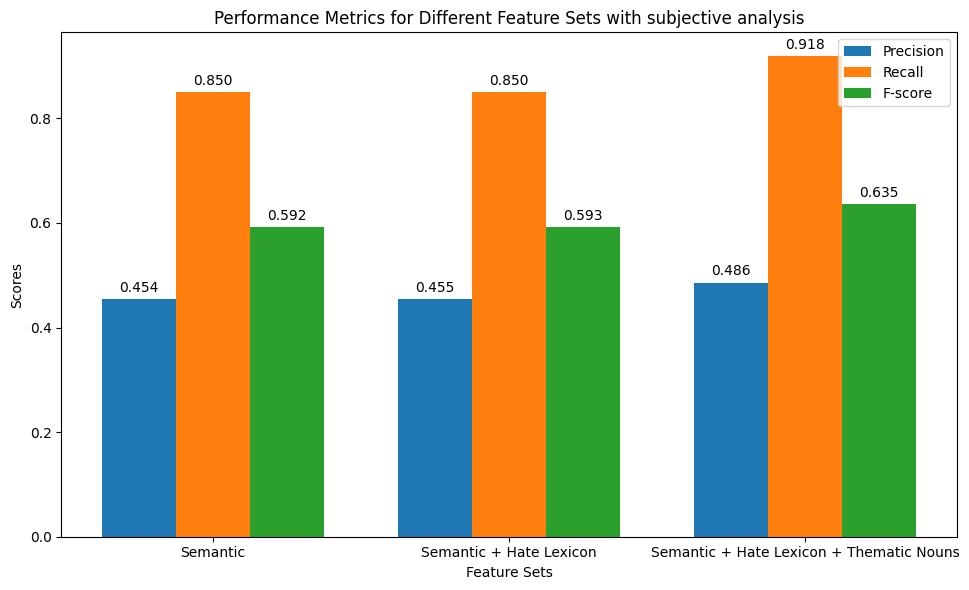

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Updated data for the different feature sets
feature_sets = [
    'Semantic',
    'Semantic + Hate Lexicon',
    'Semantic + Hate Lexicon + Thematic Nouns'
]

precision = [
    0.45376078914919854,
    0.45499383477188654,
    0.48581997533908755
]

recall = [
    0.8498845265588915,
    0.8502304147465438,
    0.9184149184149184
]

f_score = [
    0.5916398713826366,
    0.5927710843373494,
    0.635483870967742
]

# Number of feature sets
n = len(feature_sets)

# The x locations for the groups
ind = np.arange(n)

# The width of the bars
width = 0.25

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(ind - width, precision, width, label='Precision')
bar2 = ax.bar(ind, recall, width, label='Recall')
bar3 = ax.bar(ind + width, f_score, width, label='F-score')

# Adding labels
ax.set_xlabel('Feature Sets')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for Different Feature Sets with subjective analysis')
ax.set_xticks(ind)
ax.set_xticklabels(feature_sets)
ax.legend()

# Adding the scores above the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.3f' % height,  # Display scores with 3 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Show plot
plt.tight_layout()
plt.show()


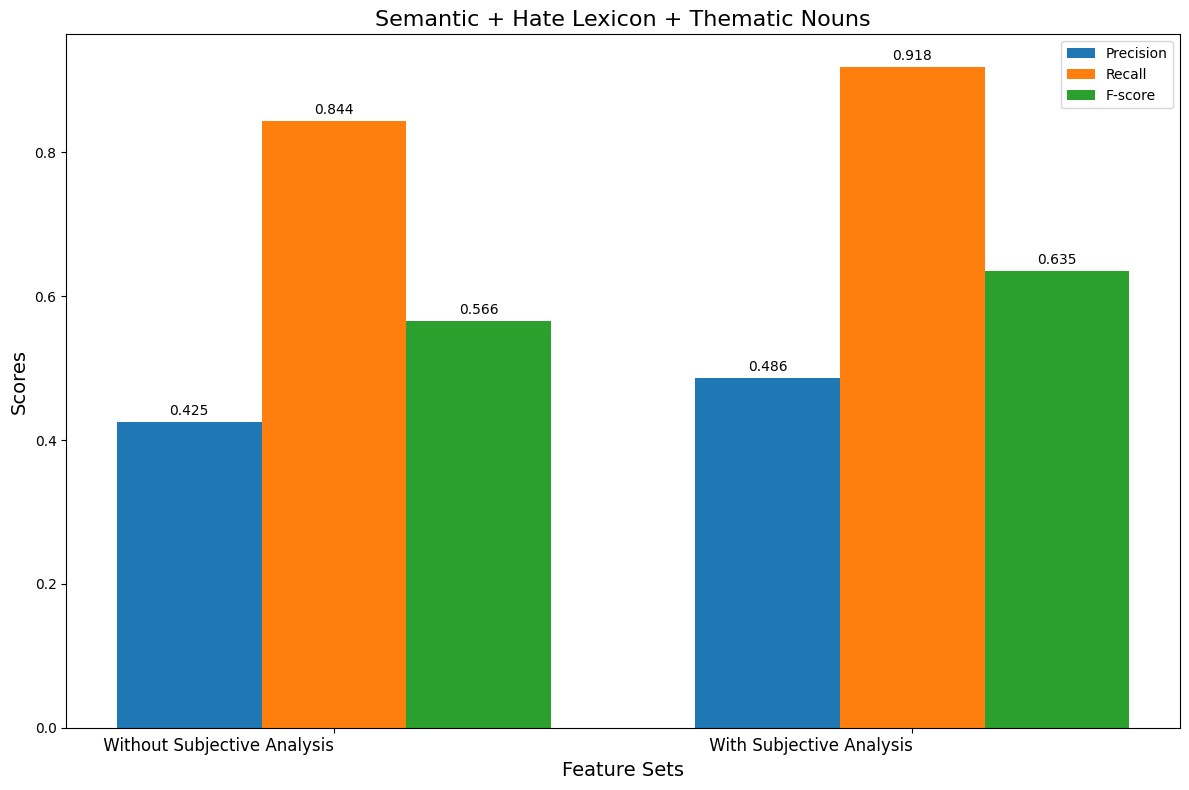

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Updated data for the different configurations
feature_sets = [
    ' Without Subjective Analysis',
    ' With Subjective Analysis'
]

precision = [
    0.4254007398273736,
    0.48581997533908755
]

recall = [
    0.843520782396088,
    0.9184149184149184
]

f_score = [
    0.5655737704918032,
    0.635483870967742
]

# Number of feature sets
n = len(feature_sets)

# The x locations for the groups
ind = np.arange(n)

# The width of the bars
width = 0.25

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar1 = ax.bar(ind - width, precision, width, label='Precision')
bar2 = ax.bar(ind, recall, width, label='Recall')
bar3 = ax.bar(ind + width, f_score, width, label='F-score')

# Adding labels
ax.set_xlabel('Feature Sets', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Semantic + Hate Lexicon + Thematic Nouns', fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(feature_sets, ha='right', fontsize=12)
ax.legend()

# Adding the scores above the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('%.3f' % height,  # Display scores with 3 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Show plot
plt.tight_layout()
plt.show()


In [16]:
import csv                                                                  # Importing the csv module

fields = ['Unique ID', 'Post', 'Labels Set', 'Total Score', 'Hate Label' ,'Subjective Hate Label']   # Defining the fields of the csv file
with open("results.csv", 'w') as csvfile:                                   # Opening the file
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)

    # writing the fields
    csvwriter.writerow(fields)

    # writing the data rows
    csvwriter.writerows(rows)

In [17]:
import pandas as pd

# Load the results CSV file into a DataFrame
df = pd.read_csv('results.csv')

# Display the first few rows of the DataFrame to understand its structure
print(df.head())


   Unique ID                                               Post   Labels Set  \
0          1  दृढ़ इच्छा शक्ति से परिपूर्ण प्रणबदा के लिए दे...  non-hostile   
1          2  भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं ...   defamation   
2          3  कोरोना से निपटने की तैयारी / दिल्ली में 10 हजा...  non-hostile   
3          4  गवर्नर कॉन्फ्रेंस में PM मोदी बोले- शिक्षा नीत...  non-hostile   
4          5  यूपी: गाजीपुर में Toilet घोटाला, प्रधान व सचिव...  non-hostile   

   Total Score        Hate Label Subjective Hate Label  
0       -0.375    weakly hateful               No Hate  
1        0.000    weakly hateful               No Hate  
2        0.875           No Hate               No Hate  
3       -1.000  strongly hateful      strongly hateful  
4        0.625           No Hate               No Hate  


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Calculate performance metrics
print("Classification Report:")
print(classification_report(df['Hate Label'], df['Subjective Hate Label']))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(df['Hate Label'], df['Subjective Hate Label'])
print(conf_matrix)

#print("Accuracy:", accuracy_score(df['Hate Label'], df['Subjective Hate Label']))


Classification Report:
                  precision    recall  f1-score   support

         No Hate       0.62      1.00      0.77       293
strongly hateful       1.00      0.75      0.86       174
  weakly hateful       1.00      0.60      0.75       344

        accuracy                           0.78       811
       macro avg       0.87      0.78      0.79       811
    weighted avg       0.86      0.78      0.78       811

Confusion Matrix:
[[293   0   0]
 [ 44 130   0]
 [136   0 208]]


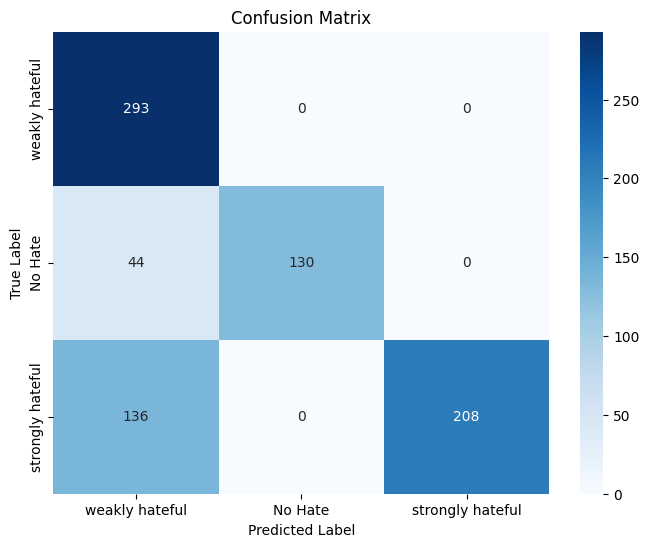

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['Hate Label'].unique(), yticklabels=df['Hate Label'].unique())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



